##### Initialization: definition of robots and coordinates

In [1]:
import numpy as np
from UAV import *
import random
import matplotlib.pyplot as plt   


n_robots = 4#int(input("number of robots: "))
n_components = 2
platoon = []


# initialization of n robots
for i in range(n_robots):
    if i==0:
        i_robot = Robot("op_" + str(i),0,0,0)
    else:
        i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

#TRUE COORDINATES [REALITY: THEY ARE UNKNOWN]
S = coordinates[0:2,:]

print(S)

[[0.         2.85790141 4.65503058 3.5830174 ]
 [0.         7.620726   6.33779049 4.97257813]]


##### Definition of the (squared) distance matrix

In [2]:
DM2 = d_matrix2(platoon) #squared distance matrix -> for formulas
print(DM2)

[[ 0.         66.24306529 61.83689796 37.56454692]
 [66.24306529  0.          4.87559678  7.53848035]
 [61.83689796  4.87559678  0.          3.01301705]
 [37.56454692  7.53848035  3.01301705  0.        ]]


##### S* estimation through EigenValue Decomposition

In [3]:
S_star = EVD(DM2,n_components)
print(S_star)

[[-6.50234778  2.0088134   1.91907121  0.67206405]
 [ 0.22518835  1.54574835 -0.46955232 -1.10073247]]


The new coordinates may be affected by rotation and flip ambiguities. Thus we must solve the problem with further analysis

##### Identification of rotation ambiguity

DM' : a new acquisition for the distances

We now introduce a displacement for the anchor, in order to build a new (squared) distance matrix.

In reality what we do is applying a displacement to the anchor and we get a new distance matrix

In [4]:
deltaX1 = deltaY1 = 0.1

DeltaS_prime = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
DeltaS_prime[:,0] = [deltaX1,deltaY1]

S_prime = S + DeltaS_prime
print(S_prime)

DM_prime = DM_from_S(S_prime,verbose=1)

[[0.1        2.85790141 4.65503058 3.5830174 ]
 [0.1        7.620726   6.33779049 4.97257813]]
DM' :
 [[ 0.         64.16733981 59.65833374 35.87342781]
 [64.16733981  0.          4.87559678  7.53848035]
 [59.65833374  4.87559678  0.          3.01301705]
 [35.87342781  7.53848035  3.01301705  0.        ]]


Estimation of the rotation angle $\theta_r$

In [5]:
theta_r = estimate_theta(DM2,DM_prime,S_star,[deltaX1,deltaY1],verbose=1)

Coordinates to work with: 1-th and 2-th
After normalization: 
cos(theta):	0.640836
sin(theta):	-0.767678

Actual theta:	 -0.8752096711392547
Approx theta:	Disabled


S** : estimated-rotated coordinates

In [6]:
S_star2 = rotateMatrix(theta_r)@S_star

##### Identification of flip ambiguity

We have to check if there is any flip ambiguity. To do so, we have to move the anchor one more time

In [7]:
deltaX2 = 0.3
deltaY2 = 0.4

DeltaS_prime2 = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
DeltaS_prime2[:,0] = [deltaX2,deltaY2]

S_prime2 = S + DeltaS_prime2
print(S_prime)

DM_prime2 = DM_from_S(S_prime2,verbose=1)

[[0.1        2.85790141 4.65503058 3.5830174 ]
 [0.1        7.620726   6.33779049 4.97257813]]
DM' :
 [[ 0.         58.68174364 54.22364722 31.68667397]
 [58.68174364  0.          4.87559678  7.53848035]
 [54.22364722  4.87559678  0.          3.01301705]
 [31.68667397  7.53848035  3.01301705  0.        ]]


Now we estimate a second rotation angle $\theta_{r2}$: if = 0, no flip ambiguity

Wrong estimated angle: -0.8752096711392547
True  estimated angle: 2.4460059979341513


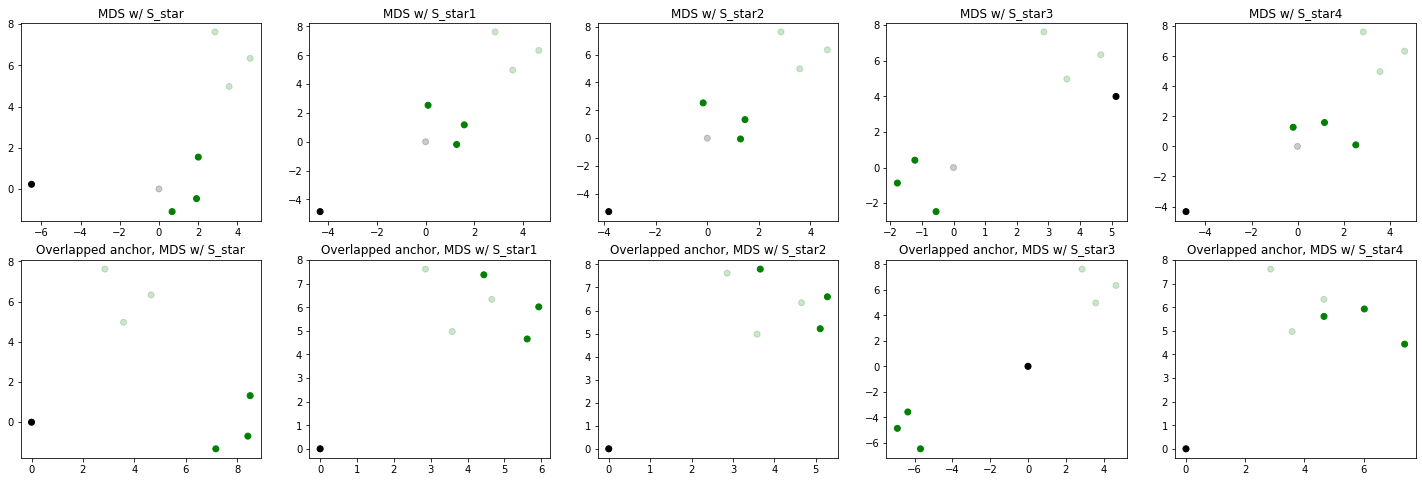

In [8]:
theta_r2 = estimate_theta(DM2,DM_prime2,S_star2,[deltaX2,deltaY2],verbose=0)

S_star3 = np.copy(S_star)
S_star4 = np.copy(S_star)

if (theta_r2 != 0):
    F = np.array([[-1,0],[0,1]])
    
    theta_r3 = estimate_theta(DM2,DM_prime,F@S_star,[deltaX1,deltaY1],verbose=0)

    print("Wrong estimated angle:",theta_r)
    print("True  estimated angle:", theta_r3)

    S_star3 = rotateMatrix(theta_r3)@F@S_star
    S_star4 = rotateMatrix(theta_r3)@S_star

plot_points(S,S_star  = S_star,
              S_star1 = rotateMatrix(theta_r)@S_star,
              S_star2 = rotateMatrix(theta_r+theta_r2)@S_star,
              S_star3 = rotateMatrix(theta_r3)@S_star,
              S_star4 = rotateMatrix(theta_r3)@F@S_star,
              match = 1
            )

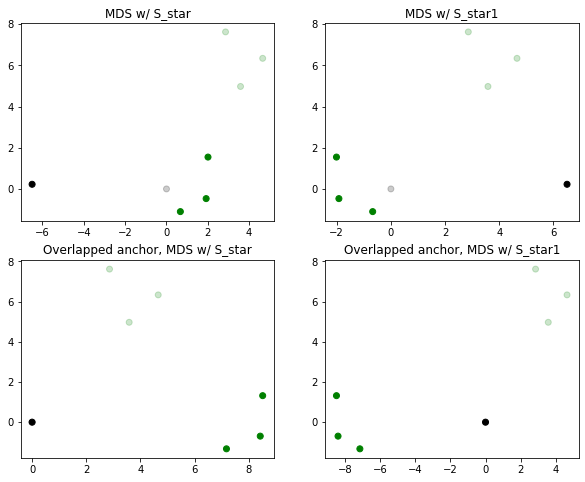

In [9]:
plot_points(S,S_star  = S_star,
              S_star1 = F@S_star,
              match = 1
            )